<a href="https://colab.research.google.com/github/sulthannauval/MachineLearning-Course/blob/main/Tugas-UTS/UTS_XGB_Credit_Card_Fraud_Detection_Sulthan_1103213065.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE
from math import sqrt
import warnings

#Loading Dataset

In [3]:
train = pd.read_csv("/content/drive/MyDrive/Datasets/train.csv")
train.head()

<ipython-input-3-73bb14c29791>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/drive/MyDrive/Datasets/train.csv")


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


Dapat dilihat data masih berantakan sehingga harus dilakukan preprocessing

#Preprocessing

##Data Cleaning

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Di atas masih banyak data yang kosong dan tidak sesuai dengan tipe yang seharusnya

In [5]:
train['Age'].unique()

array(['23', '-500', '28_', ..., '4808_', '2263', '1342'], dtype=object)

Ada banyak simbol yang salah tempat yang tidak berhubungan dengan data yang akan mempengaruhi model pelatihan.

### Data Format

In [6]:
# Age / Loans / Delayed Payments
train['Age'] = train['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
train['Num_of_Loan'] = train['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
train['Num_of_Delayed_Payment'] = train['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

# Annual Income
train['Annual_Income'] = train['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
train['Annual_Income'] = train['Annual_Income'].astype(float)

# Credit Limit
train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].replace('_', np.nan)
train['Changed_Credit_Limit'] = pd.to_numeric(train['Changed_Credit_Limit'], errors='coerce')
train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].fillna(0)

# Outstanding Debt
train['Outstanding_Debt'] = train['Outstanding_Debt'].astype(str)
train['Outstanding_Debt'] = train['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
train['Outstanding_Debt'] = pd.to_numeric(train['Outstanding_Debt'], errors='coerce')
train['Outstanding_Debt'] = train['Outstanding_Debt'].fillna(0)

# Invested Monthly
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].astype(str)
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].replace('', '0')
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
train['Amount_invested_monthly'] = pd.to_numeric(train['Amount_invested_monthly'], errors='coerce')
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].fillna(0)

# Monthly Balance
train['Monthly_Balance'] = train['Monthly_Balance'].astype(str)
train['Monthly_Balance'] = train['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
train['Monthly_Balance'] = pd.to_numeric(train['Monthly_Balance'], errors='coerce')
train['Monthly_Balance'] = train['Monthly_Balance'].fillna(0)

# Credit History Age
def parse_years_and_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0'
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0

train['Credit_History_Age_Months'] = train['Credit_History_Age'].apply(parse_years_and_months)

### Data Duplicates

In [7]:
duplicates = train[train.duplicated()]
num_duplicates = duplicates.shape[0]

if num_duplicates == 0:
    print("There are no duplicates")
else:
    print("There are", num_duplicates, "duplicates.")

There are no duplicates


Sudah dilakukan pengecekan bahwa tidak ada duplikat data pada dataset

### Data Scaling

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,119.509700,6.847573e+02,14.000000,25.000000,34.000000,42.000000,8.698000e+03
Annual_Income,100000.0,176415.701298,1.429618e+06,7005.930000,19457.500000,37578.610000,72790.920000,2.419806e+07
Monthly_Inhand_Salary,84998.0,4194.170850,3.183686e+03,303.645417,1625.568229,3093.745000,5957.448333,1.520463e+04
Num_Bank_Accounts,100000.0,17.091280,1.174048e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,100000.0,22.474430,1.290574e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,100000.0,72.466040,4.664226e+02,1.000000,8.000000,13.000000,20.000000,5.797000e+03
Num_of_Loan,100000.0,10.761960,6.178993e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
Delay_from_due_date,100000.0,21.068780,1.486010e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,100000.0,28.779410,2.181148e+02,0.000000,8.000000,13.000000,18.000000,4.397000e+03
Changed_Credit_Limit,100000.0,10.171791,6.880628e+00,-6.490000,4.970000,9.250000,14.660000,3.697000e+01


Menghapus outlier teratas yang tidak masuk akal (2%)

In [9]:
selected_columns_train = train[['Num_Bank_Accounts', 'Interest_Rate', 'Annual_Income', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Total_EMI_per_month', 'Num_of_Loan', 'Num_Credit_Card']]

percentile_threshold = 0.98
percentiles = selected_columns_train.quantile(percentile_threshold)

for column in selected_columns_train.columns:
    train = train[train[column] <= percentiles[column]]

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,85806.0,120.486003,690.067511,14.000000,25.000000,34.000000,42.000000,8698.000000
Annual_Income,85806.0,49378.620726,36478.390299,7005.930000,19294.460000,36780.030000,70825.760000,166837.640000
Monthly_Inhand_Salary,72894.0,4105.781241,3036.319177,303.645417,1623.778333,3069.091667,5899.970000,14131.123333
Num_Bank_Accounts,85806.0,5.372759,2.585031,-1.000000,3.000000,6.000000,7.000000,10.000000
Num_Credit_Card,85806.0,5.779048,5.727016,0.000000,4.000000,5.000000,7.000000,171.000000
Interest_Rate,85806.0,14.551174,8.824173,1.000000,7.000000,13.000000,20.000000,128.000000
Num_of_Loan,85806.0,7.318381,18.881665,0.000000,2.000000,3.000000,6.000000,100.000000
Delay_from_due_date,85806.0,21.033483,14.786223,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_of_Delayed_Payment,85806.0,12.348321,6.845002,0.000000,8.000000,13.000000,18.000000,25.000000
Changed_Credit_Limit,85806.0,10.189597,6.867078,-6.490000,4.990000,9.280000,14.710000,36.970000


Data sudah berkurang

## Data Entry

### Dumps Filtering

In [11]:
print(train['Occupation'].unique())
print(train['Payment_Behaviour'].unique())

['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']
['High_spent_Small_value_payments' 'Low_spent_Large_value_payments'
 'Low_spent_Medium_value_payments' 'Low_spent_Small_value_payments'
 'High_spent_Medium_value_payments' '!@9#%8'
 'High_spent_Large_value_payments']


In [12]:
train = train[train['Payment_Behaviour'] != '!@9#%8']
train = train[train['Occupation'] != '_______']

print(train['Occupation'].unique())
print(train['Payment_Behaviour'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']
['High_spent_Small_value_payments' 'Low_spent_Large_value_payments'
 'Low_spent_Medium_value_payments' 'Low_spent_Small_value_payments'
 'High_spent_Medium_value_payments' 'High_spent_Large_value_payments']


In [13]:
print(train['Credit_Mix'].unique())

['_' 'Good' 'Standard' 'Bad']


In [14]:
train = train[train['Credit_Mix'] != '_']
print(train['Credit_Mix'].unique())

['Good' 'Standard' 'Bad']


Dapat dilihat di atas bahwa simbol-simbol yang aneh sudah dihapus

### Negative Values

In [15]:
print(train['Delay_from_due_date'].unique())

[-1  3  5  6  7 13  8  0  4  9 10  1 30 31 14 11  2 -2 16 17 23 22 21 15
 12 18 19 52 51 53 48 25 20 47 61 26 29 28 58 49 45 27 55 59 57 54 62 64
 50 36 43 41 24 65 32 39 46 60 33 35 44 34 38 56 63 42 40 -3 37 -4 66 -5
 67]


In [16]:
selected_columns = ['Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Bank_Accounts']

for column in selected_columns:
    train = train[train[column] >= 0]

In [17]:
print(train['Delay_from_due_date'].unique())

[ 3  5  6  7 13  8  0  4  9 10  1 30 31 14 11 16 17 23 22 21 15 12 18 19
 52 51 53 48 25 20 47 61 26 29 28  2 58 49 45 27 55 59 57 54 62 50 36 43
 41 24 65 32 39 46 60 64 33 35 44 34 38 56 63 42 40 37 66 67]


Dapat dilihat nilai negatif sudah terhapus semua

### Column Dropping

In [18]:
columns_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Credit_History_Age','Monthly_Inhand_Salary', 'Type_of_Loan']
train.drop(columns=columns_to_drop, inplace=True)

<ipython-input-18-cba6fb499b92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=columns_to_drop, inplace=True)


### Missing Values

In [19]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 57500 entries, 2 to 99998
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        57500 non-null  int64  
 1   Occupation                 57500 non-null  object 
 2   Annual_Income              57500 non-null  float64
 3   Num_Bank_Accounts          57500 non-null  int64  
 4   Num_Credit_Card            57500 non-null  int64  
 5   Interest_Rate              57500 non-null  int64  
 6   Num_of_Loan                57500 non-null  int64  
 7   Delay_from_due_date        57500 non-null  int64  
 8   Num_of_Delayed_Payment     57500 non-null  int64  
 9   Changed_Credit_Limit       57500 non-null  float64
 10  Num_Credit_Inquiries       57500 non-null  float64
 11  Credit_Mix                 57500 non-null  object 
 12  Outstanding_Debt           57500 non-null  float64
 13  Credit_Utilization_Ratio   57500 non-null  float64


In [20]:
total_missing_values = train.isnull().sum().sum()

if total_missing_values == 0:
    print("There are no missing values")
else:
    print("Total missing values:", total_missing_values)

There are no missing values


Dapat dilihat dari ke dua output di atas bahwa sudah tidak ada nilai yang kosong dan persebaran data sudah merata

## Feature Engineering

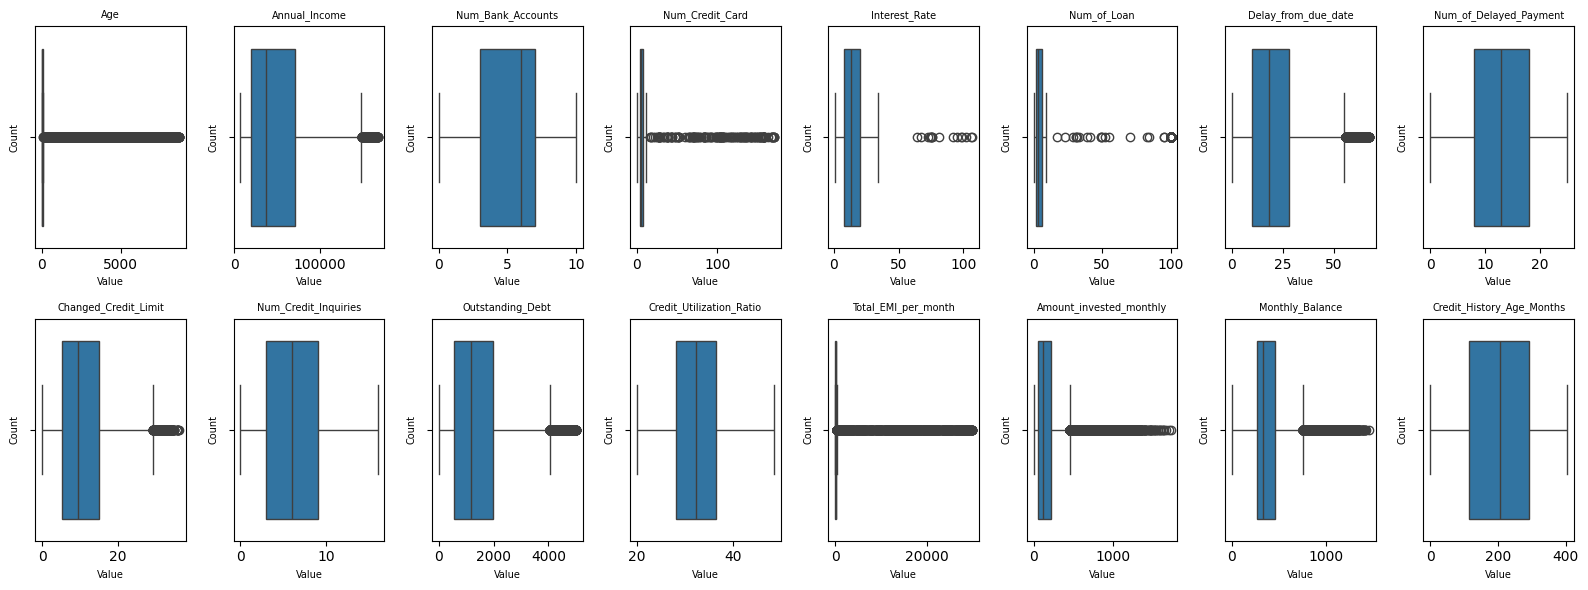

In [21]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns

num_columns = 8
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 6))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=train[column], ax=axes[i])
    axes[i].set_title(column, fontsize=7)
    axes[i].set_xlabel('Value', fontsize=7)
    axes[i].set_ylabel('Count', fontsize=7)

for j in range(len(numeric_columns), num_columns*num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Outlier sudah bersih untuk sebagian besar data sehingga lebih mudah diolah

### Data Scaling 2.0

Keputusan dibuat saat membuat EDA. Ketika melihat plot dan menyadari bahwa beberapa pencilan berada jauh di luar standar deviasi. Jadi harus memilih skala yang tepat untuk pemodelan.

In [22]:
train = train[train['Age'] < 60]
train = train[train['Num_Credit_Card'] <= 10]
train = train[train['Interest_Rate'] <= 50]
train = train[train['Num_of_Loan'] <= 12]
train = train[train['Num_Bank_Accounts'] <= 10]
train = train[train['Delay_from_due_date'] <= 60]
train = train[train['Changed_Credit_Limit'] <= 30]
train = train[train['Num_Credit_Inquiries'] <= 12]
train = train[train['Total_EMI_per_month'] <= 200]
train = train[train['Outstanding_Debt'] <= 1500]

### Encoding

#### Label Encoder

In [23]:
print(train['Credit_Score'])

3            Good
4            Good
6            Good
7        Standard
9            Good
           ...   
99976        Good
99977        Good
99979        Good
99981        Good
99998    Standard
Name: Credit_Score, Length: 30890, dtype: object


In [24]:
categories = ['Poor', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[categories])

train['Credit_Score_Encoded'] = encoder.fit_transform(train[['Credit_Score']])

In [25]:
print(train['Credit_Score_Encoded'])

3        2.0
4        2.0
6        2.0
7        1.0
9        2.0
        ... 
99976    2.0
99977    2.0
99979    2.0
99981    2.0
99998    1.0
Name: Credit_Score_Encoded, Length: 30890, dtype: float64


In [26]:
print(train['Occupation'])

3        Scientist
4        Scientist
6        Scientist
7        Scientist
9          Teacher
           ...    
99976       Writer
99977       Writer
99979       Writer
99981       Writer
99998     Mechanic
Name: Occupation, Length: 30890, dtype: object


In [27]:
label_encoder = LabelEncoder()
train['Occupation_Encoded'] = label_encoder.fit_transform(train['Occupation'])

In [28]:
print(train['Occupation_Encoded'])

3        12
4        12
6        12
7        12
9        13
         ..
99976    14
99977    14
99979    14
99981    14
99998     9
Name: Occupation_Encoded, Length: 30890, dtype: int64


#### Ordinal Encoder

In [29]:
print(train['Credit_Mix'])

3        Good
4        Good
6        Good
7        Good
9        Good
         ... 
99976    Good
99977    Good
99979    Good
99981    Good
99998    Good
Name: Credit_Mix, Length: 30890, dtype: object


In [30]:
categories = ['Bad', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[categories])

train['Credit_Mix_Encoded'] = encoder.fit_transform(train[['Credit_Mix']])

In [31]:
print(train['Credit_Mix_Encoded'])

3        2.0
4        2.0
6        2.0
7        2.0
9        2.0
        ... 
99976    2.0
99977    2.0
99979    2.0
99981    2.0
99998    2.0
Name: Credit_Mix_Encoded, Length: 30890, dtype: float64


In [32]:
print(train['Payment_Behaviour'])

3          Low_spent_Small_value_payments
4        High_spent_Medium_value_payments
6          Low_spent_Small_value_payments
7        High_spent_Medium_value_payments
9         High_spent_Large_value_payments
                       ...               
99976      Low_spent_Small_value_payments
99977     High_spent_Large_value_payments
99979      Low_spent_Small_value_payments
99981      Low_spent_Small_value_payments
99998      Low_spent_Large_value_payments
Name: Payment_Behaviour, Length: 30890, dtype: object


In [33]:
categories_payment_behaviour = [
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments'
]

encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])

train['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(train[['Payment_Behaviour']])

In [34]:
print(train['Payment_Behaviour_Encoded'])

3        0.0
4        4.0
6        0.0
7        4.0
9        5.0
        ... 
99976    0.0
99977    5.0
99979    0.0
99981    0.0
99998    2.0
Name: Payment_Behaviour_Encoded, Length: 30890, dtype: float64


Dari output-output encoding di atas fitur-fitur kategorikal sudah diubah ke dalam bentuk numerik

Dropping Unencoded columns

In [35]:
columns_to_drop = ['Payment_Behaviour', 'Credit_Mix', 'Occupation','Credit_Score']
train.drop(columns=columns_to_drop, inplace=True)

train.head().T

,3,4,6,7,9
Age,23,23,23,23,28
Annual_Income,19114.12,19114.12,19114.12,19114.12,34847.84
Num_Bank_Accounts,3,3,3,3,2
Num_Credit_Card,4,4,4,4,4
Interest_Rate,3,3,3,3,6
Num_of_Loan,4,4,4,4,1
Delay_from_due_date,5,6,3,3,7
Num_of_Delayed_Payment,4,0,8,6,1
Changed_Credit_Limit,6.27,11.27,11.27,11.27,7.42
Num_Credit_Inquiries,4.0,4.0,4.0,4.0,2.0


### New Features

Hal ini dapat membantu meningkatkan % akurasi dan mengurangi jumlah kesalahan.

In [36]:
# Calculate the total number of accounts (Bank Accounts + Credit Cards)
train['Total_Num_Accounts'] = train['Num_Bank_Accounts'] + train['Num_Credit_Card']

# Calculate the total outstanding debt per account
train['Debt_Per_Account'] = train['Outstanding_Debt'] / train['Total_Num_Accounts']

# Calculate the ratio of outstanding debt to annual income
train['Debt_to_Income_Ratio'] = train['Outstanding_Debt'] / train['Annual_Income']

# Calculate the total number of delayed payments per account
train['Delayed_Payments_Per_Account'] = train['Num_of_Delayed_Payment'] / train['Total_Num_Accounts']

# Calculate the total monthly expenses (EMI + Monthly Investments)
train['Total_Monthly_Expenses'] = train['Total_EMI_per_month'] + train['Amount_invested_monthly']

### Mutual Information Score (MI Score)

Ini akan membantu mengenali variabel yang paling berharga untuk prediksi.

In [37]:
categorical_columns = train.select_dtypes(include=['object']).columns

data_encoded = train.copy()

encoder = OrdinalEncoder()
data_encoded[categorical_columns] = encoder.fit_transform(data_encoded[categorical_columns])

y = data_encoded['Credit_Score_Encoded']
X = data_encoded.drop(columns=['Credit_Score_Encoded'])

mi_scores = mutual_info_classif(X, y)

for i, score in enumerate(mi_scores):
    print(f"Feature '{X.columns[i]}': Mutual Information Score = {score}")

Feature 'Age': Mutual Information Score = 0.009222085232682531
Feature 'Annual_Income': Mutual Information Score = 0.4294682995434098
Feature 'Num_Bank_Accounts': Mutual Information Score = 0.05370200981692119
Feature 'Num_Credit_Card': Mutual Information Score = 0.06932166671569906
Feature 'Interest_Rate': Mutual Information Score = 0.10328055863542551
Feature 'Num_of_Loan': Mutual Information Score = 0.01908718723156766
Feature 'Delay_from_due_date': Mutual Information Score = 0.06878979146982767
Feature 'Num_of_Delayed_Payment': Mutual Information Score = 0.051236598308177284
Feature 'Changed_Credit_Limit': Mutual Information Score = 0.10436780088411068
Feature 'Num_Credit_Inquiries': Mutual Information Score = 0.034051639754275165
Feature 'Outstanding_Debt': Mutual Information Score = 0.4291123994611916
Feature 'Credit_Utilization_Ratio': Mutual Information Score = 0.0008940600062685711
Feature 'Payment_of_Min_Amount': Mutual Information Score = 0.06969719550788045
Feature 'Total_E

In [38]:
sorted_mi_scores = sorted(zip(X.columns, mi_scores), key=lambda x: x[1], reverse=True)
sorted_columns = [x[0] for x in sorted_mi_scores]
sorted_scores = [x[1] for x in sorted_mi_scores]

colorscale = 'Viridis'

fig = go.Figure(data=[go.Bar(x=sorted_columns, y=sorted_scores, marker=dict(color=sorted_scores, colorbar=dict(title='Mutual Information Score', len=0.5, y=0.2)))])

fig.update_layout(title='Mutual Information Scores for Each Feature',
                  xaxis_title='Features',
                  yaxis_title='Mutual Information Score')

fig.show()

**Annual Income**: Dengan Mutual Information Score yang tinggi yaitu 0,430, Annual Income tampaknya menjadi prediktor yang signifikan terhadap tingkat Credit Score. Umumnya, individu dengan Annual Income yang lebih tinggi cenderung memiliki Credit Score yang lebih baik.

**Outstanding Debt**: Faktor krusial lainnya adalah Outstanding Debt, yang memiliki Mutual Information Score sebesar 0,429. Tingginya tingkat Outstanding Debt dapat berdampak negatif pada tingkat Credit Score.

**Debt-to-Income Ratio**: Fitur ini juga menunjukkan tingkat kepentingan yang tinggi dengan Mutual Information Score sebesar 0,433. Fitur ini mengukur proporsi utang seseorang relatif terhadap pendapatannya dan merupakan indikator yang kuat untuk Credit Score.

**Total EMI per Month**: Total Equated Monthly Installment (EMI) memiliki bobot yang cukup besar (Mutual Information Score sebesar 0,349) dalam memprediksi tingkat Credit Score. Komitmen EMI yang lebih tinggi dapat menunjukkan tekanan keuangan yang lebih tinggi dan berdampak negatif pada Credit Score.

**Interest Rate**: Meskipun tidak setinggi debt-related features, tingkat Interest Rate masih memiliki nilai yang signifikan dengan Mutual Information Score sebesar 0,100. Interest Rate yang lebih tinggi dapat mengindikasikan perilaku peminjaman yang lebih berisiko dan dapat berdampak negatif pada Credit Score.

Dropping low related values for MI Score

Walaupun baru saja membuat fitur baru, beberapa di antaranya tampaknya tidak efektif untuk model

In [39]:
columns_to_drop = ['Payment_of_Min_Amount', 'Age', 'Monthly_Balance', 'Total_Monthly_Expenses', 'Payment_Behaviour_Encoded', 'Amount_invested_monthly', 'Credit_Utilization_Ratio', 'Occupation_Encoded']
train.drop(columns=columns_to_drop, inplace=True)

In [40]:
train.head().T

,3,4,6,7,9
Annual_Income,19114.120000,19114.120000,19114.120000,19114.120000,34847.840000
Num_Bank_Accounts,3.000000,3.000000,3.000000,3.000000,2.000000
Num_Credit_Card,4.000000,4.000000,4.000000,4.000000,4.000000
Interest_Rate,3.000000,3.000000,3.000000,3.000000,6.000000
Num_of_Loan,4.000000,4.000000,4.000000,4.000000,1.000000
Delay_from_due_date,5.000000,6.000000,3.000000,3.000000,7.000000
Num_of_Delayed_Payment,4.000000,0.000000,8.000000,6.000000,1.000000
Changed_Credit_Limit,6.270000,11.270000,11.270000,11.270000,7.420000
Num_Credit_Inquiries,4.000000,4.000000,4.000000,4.000000,2.000000
Outstanding_Debt,809.980000,809.980000,809.980000,809.980000,605.030000


# EDA

## Correlation Matrix

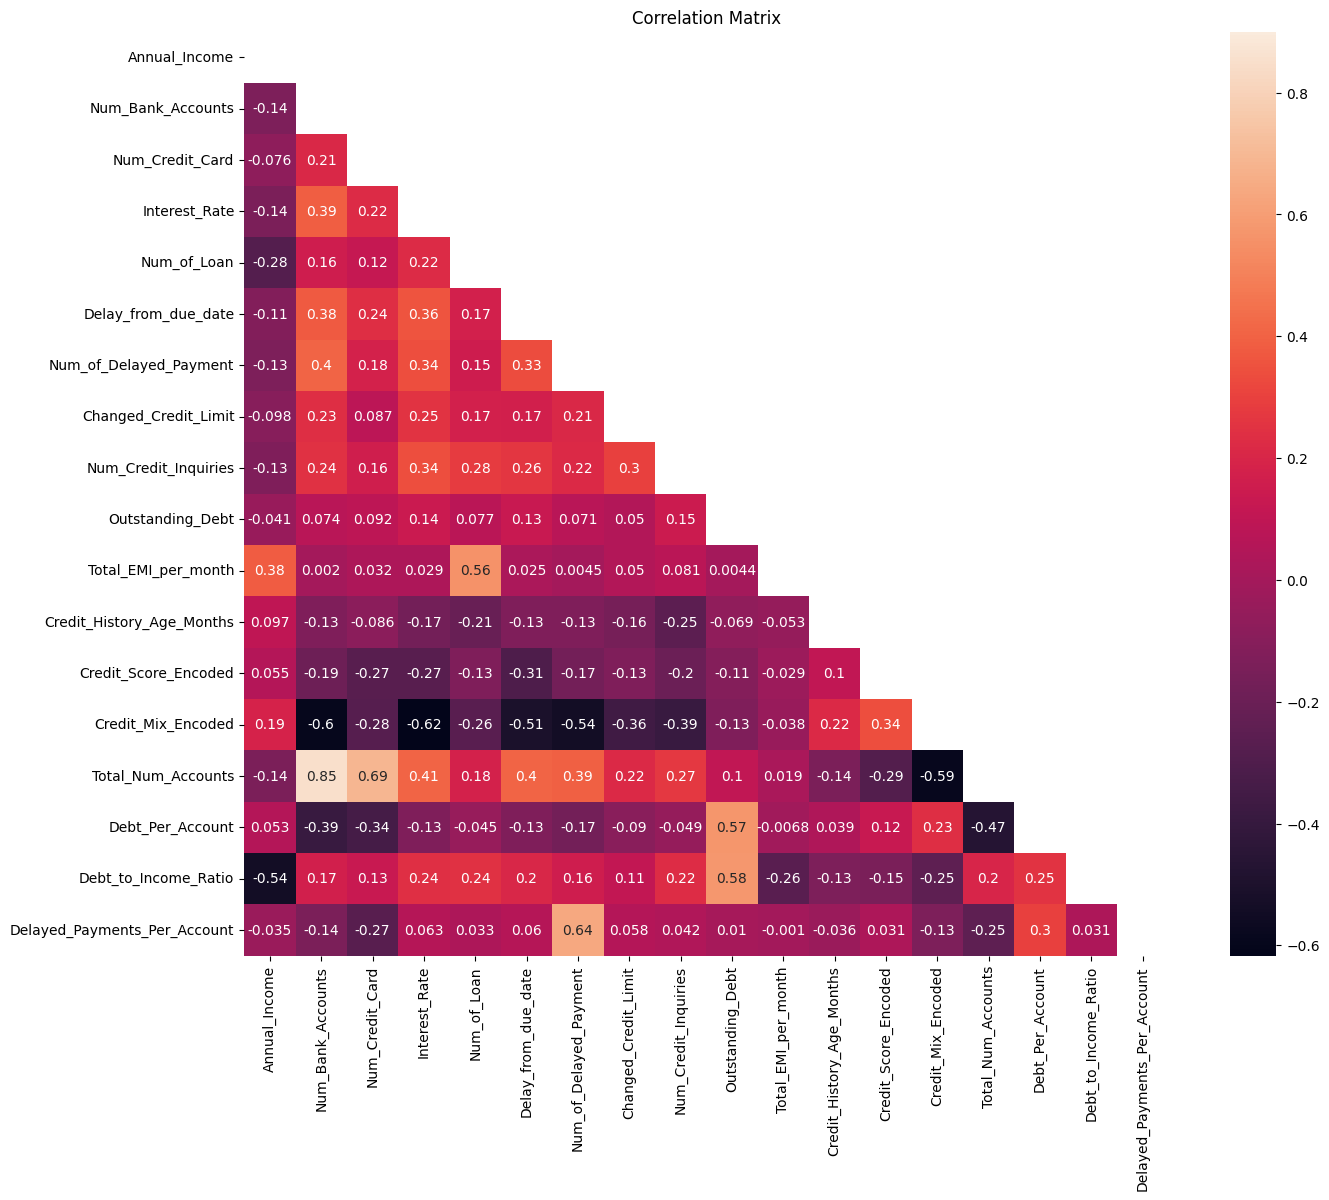

In [41]:
corr = train.select_dtypes(include=['float64', 'int64']).corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(corr, mask=mask, vmax=0.9, square=True, annot=True)
plt.title('Correlation Matrix')
plt.show()

**Financial Stability Indicators**: Features seperti 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', dan 'Total_Num_Accounts' menunjukkan korelasi positif satu sama lain dan dengan Credit Score Hal ini menunjukkan bahwa individu dengan annual incomes yang lebih tinggi atau rekening bank dan kartu kredit yang lebih beragam cenderung memiliki Credit Score yang lebih tinggi.

**Debt-related Metrics**: 'Debt_to_Income_Ratio' dan 'Debt_Per_Account'menunjukkan korelasi negatif dengan Credit Score. Hal ini mengindikasikan bahwa individu dengan debt-to-income ratios yang lebih tinggi atau greater debt per account yang lebih besar cenderung memiliki Credit Score yang lebih rendah. Selain itu, 'Outstanding_Debt' menunjukkan korelasi negatif yang lebih lemah dengan Credit Score, yang meng-highlight dampaknya terhadap kelayakan kredit secara keseluruhan.

**Credit Utilization dan History**: 'Total_EMI_per_month', yang menunjukkan pembayaran pinjaman bulanan, menunjukkan korelasi positif dengan Credit Score. Selain itu, fitur yang terkait dengan Credit History, seperti 'Credit_History_Age_Months' dan 'Credit_Mix_Encoded" menunjukkan bahwa individu dengan Credit History yang lebih panjang, Credit Accounts yang beragam, dan pembayaran yang tepat waktu cenderung memiliki Credit Score yang lebih tinggi.

**Loan-related Factors**: Fitur seperti 'Num_of_Loan' dan 'Num_of_Delayed_Payment'menunjukkan perilaku peminjaman dan pola pembayaran seseorang. Hal ini mengimplikasikan bahwa individu dengan jumlah pinjaman atau kasus penundaan pembayaran yang lebih sedikit cenderung memiliki Credit Score yang lebih tinggi.

**Interest Rate and Financial Behavior**: 'Interest_Rate' menunjukkan bahwa individu dengan Interest rates yang lebih rendah pada pinjaman mereka mungkin memiliki Credit Score yang lebih tinggi. Selain itu, 'Changed_Credit_Limit' dan 'Num_Credit_Inquiries' juga menunjukkan korelasi, yang mencerminkan perubahan batas kredit dan frekuensi pertanyaan kredit.

# Model

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30890 entries, 3 to 99998
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual_Income                 30890 non-null  float64
 1   Num_Bank_Accounts             30890 non-null  int64  
 2   Num_Credit_Card               30890 non-null  int64  
 3   Interest_Rate                 30890 non-null  int64  
 4   Num_of_Loan                   30890 non-null  int64  
 5   Delay_from_due_date           30890 non-null  int64  
 6   Num_of_Delayed_Payment        30890 non-null  int64  
 7   Changed_Credit_Limit          30890 non-null  float64
 8   Num_Credit_Inquiries          30890 non-null  float64
 9   Outstanding_Debt              30890 non-null  float64
 10  Total_EMI_per_month           30890 non-null  float64
 11  Credit_History_Age_Months     30890 non-null  int64  
 12  Credit_Score_Encoded          30890 non-null  float64
 13  Credit

## SMOTE

In [43]:
smote_params = {
    'sampling_strategy': 'auto',
    'random_state': 77,
    'k_neighbors': 5,
}

smote = SMOTE(**smote_params)

X_train = train.drop('Credit_Score_Encoded', axis=1)
y_train = train['Credit_Score_Encoded']

X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.15, random_state=77)

SMOTE (Synthetic Minority Over-sampling Technique) adalah teknik oversampling yang umum digunakan dalam pemrosesan data yang tidak seimbang (imbalanced data) pada masalah klasifikasi. Teknik ini bertujuan untuk menangani masalah ketidakseimbangan kelas di mana jumlah sampel untuk kelas minoritas jauh lebih sedikit dibandingkan dengan kelas mayoritas dalam dataset.

## XGBoost Classifier

In [44]:
xgb_classifier = XGBClassifier(n_estimators=500)
xgb_classifier.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Evaluation

In [45]:
print("Accuracy on SMOTE Training Set:", xgb_classifier.score(X_train_smote, y_train_smote))

y_pred_smote = xgb_classifier.predict(X_test_smote)
accuracy_smote = accuracy_score(y_test_smote, y_pred_smote)

print("Accuracy on SMOTE Test Set:", accuracy_smote)

Accuracy on SMOTE Training Set: 0.9896982776171668
Accuracy on SMOTE Test Set: 0.8975542224273189


XGBoost Classifier memiliki akurasi ±98.9% untuk Training Set yang menggunakan SMOTE dan ±89.7% untuk Test Set yang menggunakan SMOTE

Accuracy on Original Test Set: 0.9519261897054063
Mean Squared Error (MSE): 0.04807381029459372
Root Mean Squared Error (RMSE): 0.21925740647602698
Mean Absolute Error (MAE): 0.04807381029459372
R-squared (R2): 0.8717697238158415

Classification report for original test set:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       901
         1.0       0.97      0.95      0.96      3810
         2.0       0.92      0.96      0.94      1467

    accuracy                           0.95      6178
   macro avg       0.94      0.95      0.95      6178
weighted avg       0.95      0.95      0.95      6178



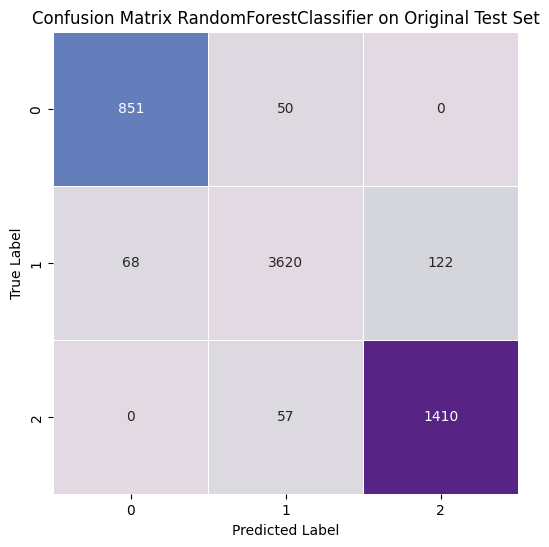

In [46]:
y = train['Credit_Score_Encoded']
X = train.drop('Credit_Score_Encoded', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

y_pred = xgb_classifier.predict(X_test)
y_pred = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print("Accuracy on Original Test Set:", accuracy)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r_squared)

matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(matrix, annot=True, cbar=False, cmap='twilight', linewidth=0.5, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix RandomForestClassifier on Original Test Set')

print('\nClassification report for original test set:\n', classification_report(y_test, y_pred))

Tanpa Menggunakan SMOTE didapatkan akurasi Test Set ±95.1% dan persebarannya bisa dilihat pada Confussion Matrix. Selain itu MSE sebesar 0.04807, RMSE sebesar 0.21925, MAE sebesar 0.04807, dan R2 sebesar 0.87176

In [47]:
train.columns

Index(['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Credit_History_Age_Months', 'Credit_Score_Encoded',
       'Credit_Mix_Encoded', 'Total_Num_Accounts', 'Debt_Per_Account',
       'Debt_to_Income_Ratio', 'Delayed_Payments_Per_Account'],
      dtype='object')

# Pengujian Pada Dataset Test

Kita terapkan Preprocessing pada Dataset Train untuk Dataset Test

## Loading Dataset

In [48]:
test = pd.read_csv("/content/drive/MyDrive/Datasets/test.csv")
test.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


#Preprocessing

In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

## Data Format

In [50]:
# Age / Loans / Delayed Payments
test['Age'] = test['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
test['Num_of_Loan'] = test['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
test['Num_of_Delayed_Payment'] = test['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

# Annual Income
test['Annual_Income'] = test['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
test['Annual_Income'] = test['Annual_Income'].astype(float)

# Credit Limit
test['Changed_Credit_Limit'] = test['Changed_Credit_Limit'].replace('_', np.nan)
test['Changed_Credit_Limit'] = pd.to_numeric(test['Changed_Credit_Limit'], errors='coerce')
test['Changed_Credit_Limit'] = test['Changed_Credit_Limit'].fillna(0)

# Outstanding Debt
test['Outstanding_Debt'] = test['Outstanding_Debt'].astype(str)
test['Outstanding_Debt'] = test['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
test['Outstanding_Debt'] = pd.to_numeric(test['Outstanding_Debt'], errors='coerce')
test['Outstanding_Debt'] = test['Outstanding_Debt'].fillna(0)

# Invested Monthly
test['Amount_invested_monthly'] = test['Amount_invested_monthly'].astype(str)
test['Amount_invested_monthly'] = test['Amount_invested_monthly'].replace('', '0')
test['Amount_invested_monthly'] = test['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
test['Amount_invested_monthly'] = pd.to_numeric(test['Amount_invested_monthly'], errors='coerce')
test['Amount_invested_monthly'] = test['Amount_invested_monthly'].fillna(0)

# Monthly Balance
test['Monthly_Balance'] = test['Monthly_Balance'].astype(str)
test['Monthly_Balance'] = test['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
test['Monthly_Balance'] = pd.to_numeric(test['Monthly_Balance'], errors='coerce')
test['Monthly_Balance'] = test['Monthly_Balance'].fillna(0)

# Credit History Age
def parse_years_and_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0'
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0

test['Credit_History_Age_Months'] = test['Credit_History_Age'].apply(parse_years_and_months)

## Data Entry

In [51]:
test = test[test['Payment_Behaviour'] != '!@9#%8']
test = test[test['Occupation'] != '_______']
test = test[test['Credit_Mix'] != '_']

## Encoding

In [52]:
label_encoder = LabelEncoder()
test['Occupation_Encoded'] = label_encoder.fit_transform(test['Occupation'])

categories = ['Bad', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[categories])

test['Credit_Mix_Encoded'] = encoder.fit_transform(test[['Credit_Mix']])

categories_payment_behaviour = [
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments'
]

encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])

test['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(test[['Payment_Behaviour']])

## New Features

In [53]:
# Calculate the total number of accounts (Bank Accounts + Credit Cards)
test['Total_Num_Accounts'] = test['Num_Bank_Accounts'] + test['Num_Credit_Card']

# Calculate the total outstanding debt per account
test['Debt_Per_Account'] = test['Outstanding_Debt'] / test['Total_Num_Accounts']

# Calculate the ratio of outstanding debt to annual income
test['Debt_to_Income_Ratio'] = test['Outstanding_Debt'] / test['Annual_Income']

# Calculate the total number of delayed payments per account
test['Delayed_Payments_Per_Account'] = test['Num_of_Delayed_Payment'] / test['Total_Num_Accounts']

# Calculate the total monthly expenses (EMI + Monthly Investments)
test['Total_Monthly_Expenses'] = test['Total_EMI_per_month'] + test['Amount_invested_monthly']

In [54]:
columns_to_drop = [
    'ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
    'Monthly_Inhand_Salary', 'Type_of_Loan', 'Credit_Mix', 'Credit_Utilization_Ratio',
    'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour',
    'Monthly_Balance', 'Occupation_Encoded', 'Payment_Behaviour_Encoded',
    'Total_Monthly_Expenses', 'Credit_History_Age'
]

# Hapus kolom-kolom yang tidak diperlukan
test_cleaned = test.drop(columns=columns_to_drop)

test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34521 entries, 0 to 49998
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual_Income                 34521 non-null  float64
 1   Num_Bank_Accounts             34521 non-null  int64  
 2   Num_Credit_Card               34521 non-null  int64  
 3   Interest_Rate                 34521 non-null  int64  
 4   Num_of_Loan                   34521 non-null  int64  
 5   Delay_from_due_date           34521 non-null  int64  
 6   Num_of_Delayed_Payment        34521 non-null  int64  
 7   Changed_Credit_Limit          34521 non-null  float64
 8   Num_Credit_Inquiries          33808 non-null  float64
 9   Outstanding_Debt              34521 non-null  float64
 10  Total_EMI_per_month           34521 non-null  float64
 11  Credit_History_Age_Months     34521 non-null  int64  
 12  Credit_Mix_Encoded            34521 non-null  float64
 13  Total_

# Prediksi

In [55]:
y_pred = xgb_classifier.predict(test_cleaned)

## Hasil Prediksi

In [57]:
value_counts = pd.Series(y_pred).value_counts()
hasil = pd.DataFrame({'Credit Score': value_counts.index, 'Jumlah': value_counts.values})
hasil

,Credit Score,Jumlah
0,1,18179
1,0,10990
2,2,5352
